Train shape: (517754, 14)
Test shape: (172585, 13)
Sample shape: (172585, 2)
Train columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']
Column data types:
id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object
Target skewness: 0.378


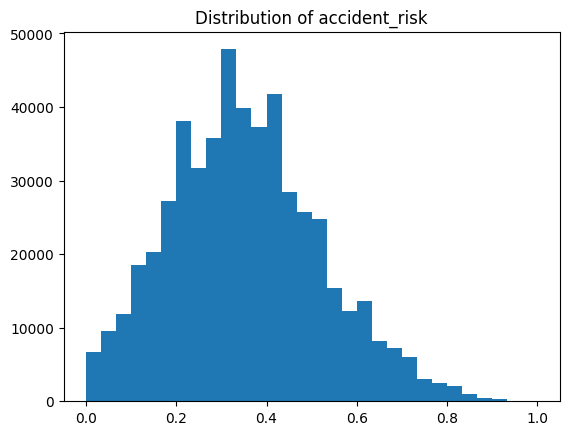

Preprocessing complete.
Training fold 1...
Fold 1 RMSE: 0.05622
Training fold 2...
Fold 2 RMSE: 0.05607
Training fold 3...
Fold 3 RMSE: 0.05611
Training fold 4...
Fold 4 RMSE: 0.05594
Training fold 5...
Fold 5 RMSE: 0.05591
Mean CV RMSE: 0.05605 ± 0.00011


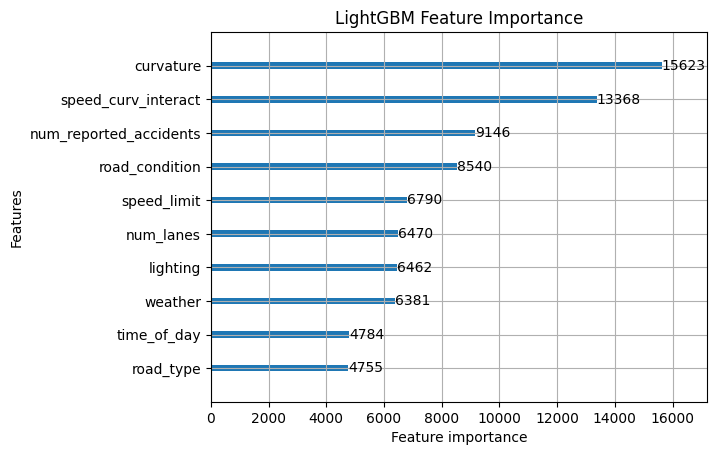

Submission saved as submission_lgbm_rf_ensemble.csv
       id  accident_risk
0  517754       0.297339
1  517755       0.122402
2  517756       0.182483
3  517757       0.312270
4  517758       0.405534


In [2]:
# Install required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Sample shape: {sample.shape}')
print(f'Train columns: {train.columns.tolist()}')
print('Column data types:')
print(train.dtypes)

# Check target skewness
y = train['accident_risk']
print(f'Target skewness: {y.skew():.3f}')
plt.hist(y, bins=30)
plt.title('Distribution of accident_risk')
plt.show()

# Preprocessing
# Drop id
train_id = train['id']
test_id = test['id']
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# Target (log-transform if skewed)
use_log_transform = y.skew() > 1 or y.skew() < -1
if use_log_transform:
    print('Applying log1p transformation to target due to skewness.')
    y = np.log1p(y)

train = train.drop('accident_risk', axis=1)

# Combine for preprocessing
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# Feature engineering
all_data['speed_curv_interact'] = all_data['speed_limit'] * all_data['curvature']
all_data['bad_weather'] = np.where(all_data['weather'].isin(['rainy', 'foggy']), 1, 0)
all_data['poor_lighting'] = np.where(all_data['lighting'].isin(['dim', 'night']), 1, 0)
all_data['rush_hour'] = np.where(all_data['time_of_day'].isin(['morning', 'evening']), 1, 0)
all_data['road_condition'] = all_data['curvature'] * all_data['bad_weather']
all_data['holiday_rush'] = all_data['holiday'] * all_data['rush_hour']
# New feature
all_data['speed_limit_sq'] = all_data['speed_limit'] ** 2  # Polynomial feature
all_data['speed_poor_lighting'] = all_data['speed_limit'] * all_data['poor_lighting']  # Numeric interaction

# Encode categoricals
cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))
    label_encoders[col] = le

# Boolean cols to int
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    all_data[col] = all_data[col].astype(int)

# Handle outliers
num_cols = ['speed_limit', 'curvature', 'speed_curv_interact', 'road_condition', 'speed_limit_sq', 'speed_poor_lighting']
for col in num_cols:
    upper_limit = all_data[col].quantile(0.99)
    all_data[col] = np.clip(all_data[col], None, upper_limit)

# Split back
train = all_data[:len(train)].reset_index(drop=True)
test = all_data[len(train):].reset_index(drop=True)

# Prepare X
X = train
X_test = test

print('Preprocessing complete.')

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgbm_preds = np.zeros(len(X_test))
rf_preds = np.zeros(len(X_test))
val_rmse = []

# LightGBM parameters
lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'n_jobs': -1,
    'random_state': 42,
    'learning_rate': 0.015,
    'n_estimators': 4000,
    'num_leaves': 40,
    'min_data_in_leaf': 20,
    'max_depth': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

# Random Forest parameters
rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'random_state': 42
}

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'Training fold {fold + 1}...')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM
    lgbm_model = lgb.LGBMRegressor(**lgbm_params)
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    
    # Random Forest
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)
    
    # Validation predictions
    lgbm_val_pred = lgbm_model.predict(X_val)
    rf_val_pred = rf_model.predict(X_val)
    
    # Stack predictions (weighted average)
    val_pred = 0.7 * lgbm_val_pred + 0.3 * rf_val_pred
    if use_log_transform:
        val_pred = np.expm1(val_pred)
        y_val = np.expm1(y_val)
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_rmse.append(fold_rmse)
    print(f'Fold {fold + 1} RMSE: {fold_rmse:.5f}')
    
    # Test predictions
    lgbm_preds += lgbm_model.predict(X_test) / kf.n_splits
    rf_preds += rf_model.predict(X_test) / kf.n_splits

# Stack test predictions
test_preds = 0.7 * lgbm_preds + 0.3 * rf_preds
if use_log_transform:
    test_preds = np.expm1(test_preds)

# Ensure predictions are between 0 and 1
test_preds = np.clip(test_preds, 0.01, 0.99)

print(f'Mean CV RMSE: {np.mean(val_rmse):.5f} ± {np.std(val_rmse):.5f}')

# Feature importance (from last LightGBM model)
lgb.plot_importance(lgbm_model, max_num_features=10)
plt.title('LightGBM Feature Importance')
plt.show()

# Submission
submission = pd.DataFrame({'id': test_id, 'accident_risk': test_preds})
submission.to_csv('submission_lgbm_rf_ensemble.csv', index=False)
print('Submission saved as submission_lgbm_rf_ensemble.csv')
print(submission.head())